### Now lets make the workflow wait for the user input during runtime

In [1]:
from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, AnyMessage
from langchain_core.tools import tool

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Send
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import InMemorySaver

from typing import Annotated, TypedDict, Literal
from pydantic import BaseModel, Field
from dotenv import load_dotenv
import operator
import requests
import os

load_dotenv()

/Users/srinivas/Documents/Others/My_projects/Python/DSAIML/agenticai/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
model = init_chat_model(
    model="qwen/qwen3-32b",  # or any other Groq model
    model_provider="groq",
    temperature=0.7,
)

In [3]:
# Lets create some custom tools

@tool
def get_weather_tool(city: str):
    """
    Given a city name, this function will provide weather information about the city.
    Uses Weatherstack API to fetch the weather.
    """
    url = f'https://api.weatherstack.com/current?access_key={os.getenv("WEATHER_API_KEY")}&query={city}'

    response = requests.get(url)

    return response.json()

@tool
def add_tool(a: int, b: int) -> int:
    """Add two numbers given two inputs."""
    return a + b

@tool
def subtract_tool(a: int, b: int) -> int:
    """Subtract two numbers given two inputs."""
    return a - b

@tool
def multiply_tool(a: int, b: int) -> int:
    """Multiply two numbers given two inputs."""
    return a * b

@tool
def divide_tool(a: int, b: int) -> int:
    """Divide two numbers given two inputs."""
    if b == 0:
        raise ValueError("Cannot divide by zero")
    return a / b

In [4]:
# lets create a tool list 

tools = [
    get_weather_tool,
    add_tool,
    subtract_tool,
    multiply_tool,
    divide_tool,
]

# now bind the model with tools

model_with_tools = model.bind_tools(tools=tools)

In [5]:
# create a chat state
class ChatState(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]

In [6]:
def chat_node(state: ChatState) -> ChatState:
    system_message = SystemMessage(content="You are a helpful assistant. Respond in a friendly and conversational manner. Use the tools below to answer the user's questions whenever possible.")
    messages = [system_message] + state.messages
    response = model_with_tools.invoke(messages)
    return {"messages": state.messages + [response]}

tool_node = ToolNode(tools)

In [9]:
def human_feedback_node(state: ChatState) -> ChatState:
    pass

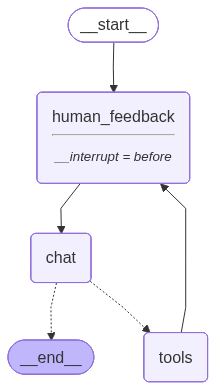

In [10]:
# Build the graph
graph = StateGraph(ChatState)

# add nodes
graph.add_node("chat", chat_node)
graph.add_node("tools", tool_node)
graph.add_node("human_feedback", human_feedback_node)

# add edges
graph.add_edge(START, "human_feedback")
graph.add_edge("human_feedback", "chat")
graph.add_conditional_edges("chat", tools_condition)
graph.add_edge("tools", "human_feedback")
graph.add_edge("chat", END)

# add memory
memory = InMemorySaver()

# compile the graph
# to add human in the loop (human feedback) 
workflow = graph.compile(interrupt_before=["human_feedback"], checkpointer=memory)
workflow

In [11]:
config = {"configurable": {"thread_id": "chat_1"}}
initial_state = {"messages": [HumanMessage(content="Hello, I'm Srini, What is the weather today in Dallas?")]}

response = workflow.stream(initial_state, config=config, stream_mode="values")
for event in response:
    event["messages"][-1].pretty_print()

user_input = input("Tell me if you want to update the message, or continue with execution: ")

workflow.update_state(config, { "messages": [HumanMessage(content=user_input)]}, as_node="human_feedback")

response = workflow.stream(None, config=config, stream_mode="values")
for event in response:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hello, I'm Srini, What is the weather today in Dallas?
================================ Human Message =================================

No tell me the weather in Chicago
================================== Ai Message ==================================
Tool Calls:
  get_weather_tool (1bv1f9awj)
 Call ID: 1bv1f9awj
  Args:
    city: Chicago
================================= Tool Message =================================
Name: get_weather_tool

{"request": {"type": "City", "query": "Chicago, United States of America", "language": "en", "unit": "m"}, "location": {"name": "Chicago", "country": "United States of America", "region": "Illinois", "lat": "41.850", "lon": "-87.650", "timezone_id": "America/Chicago", "localtime": "2025-11-30 17:15", "localtime_epoch": 1764522900, "utc_offset": "-6.0"}, "current": {"observation_time": "11:15 PM", "temperature": -1, "weather_code": 116, "weather_icons": ["https://cdn.w

In [12]:
response = workflow.stream(None, config=config, stream_mode="values")
for event in response:
    event["messages"][-1].pretty_print()


================================= Tool Message =================================
Name: get_weather_tool

{"request": {"type": "City", "query": "Chicago, United States of America", "language": "en", "unit": "m"}, "location": {"name": "Chicago", "country": "United States of America", "region": "Illinois", "lat": "41.850", "lon": "-87.650", "timezone_id": "America/Chicago", "localtime": "2025-11-30 17:15", "localtime_epoch": 1764522900, "utc_offset": "-6.0"}, "current": {"observation_time": "11:15 PM", "temperature": -1, "weather_code": 116, "weather_icons": ["https://cdn.worldweatheronline.com/images/wsymbols01_png_64/wsymbol_0004_black_low_cloud.png"], "weather_descriptions": ["Partly cloudy"], "astro": {"sunrise": "06:58 AM", "sunset": "04:20 PM", "moonrise": "01:25 PM", "moonset": "01:34 AM", "moon_phase": "Waxing Gibbous", "moon_illumination": 68}, "air_quality": {"co": "212.85", "no2": "15.55", "o3": "68", "so2": "3.25", "pm2_5": "5.45", "pm10": "6.05", "us-epa-index": "1", "gb-defr